✓ Directories created/verified

Libraries loaded successfully!
NumPy version: 2.3.3
Pandas version: 2.3.3

GENERATING SIMULATED STRUCTURAL VARIANT DATA

✓ Generated 1000 structural variants

SV Type Distribution:
sv_type
deletion       484
duplication    290
inversion      226
Name: count, dtype: int64

Chromosome Distribution (first 5):
chromosome
chr3     58
chr14    52
chr16    52
chr13    50
chr12    49
Name: count, dtype: int64

✓ Data saved to data/structural_variants.csv

SEQUENCE FEATURE ANALYSIS

--- GC Content by SV Type ---
                 mean       std  count
sv_type                               
deletion     0.646029  0.061922    484
duplication  0.411739  0.045305    290
inversion    0.515957  0.045671    226

--- Microhomology by SV Type ---
                 mean       std
sv_type                        
deletion     2.328512  0.697179
duplication  2.213793  0.687870
inversion    2.314159  0.682136

--- Repeat Elements by SV Type ---
sv_type      has_repeat
deletion  

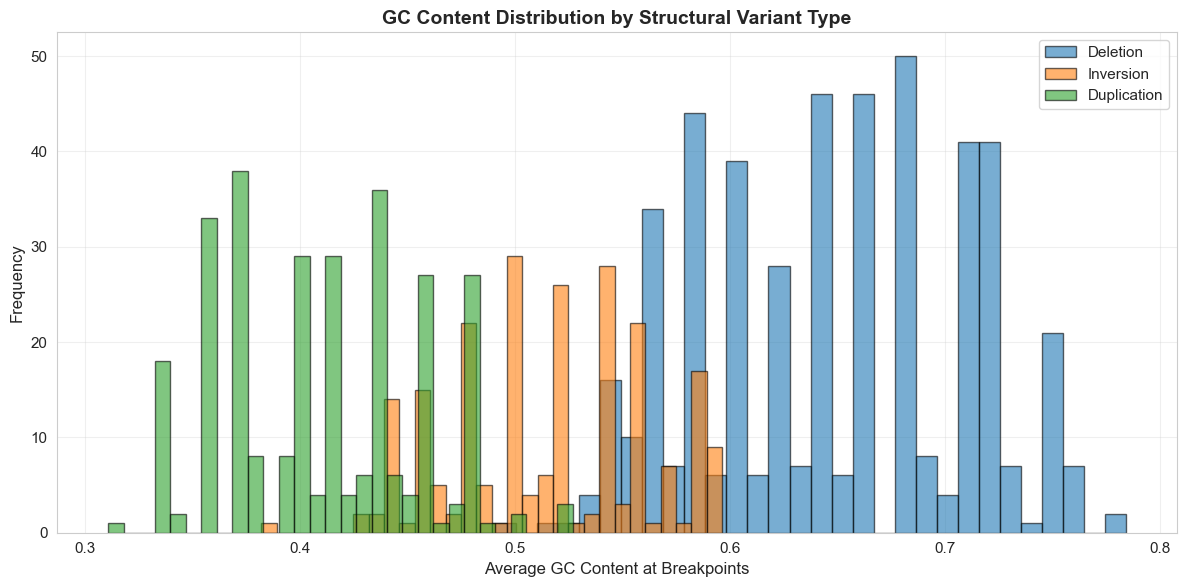

✓ Saved: gc_content_distribution.png


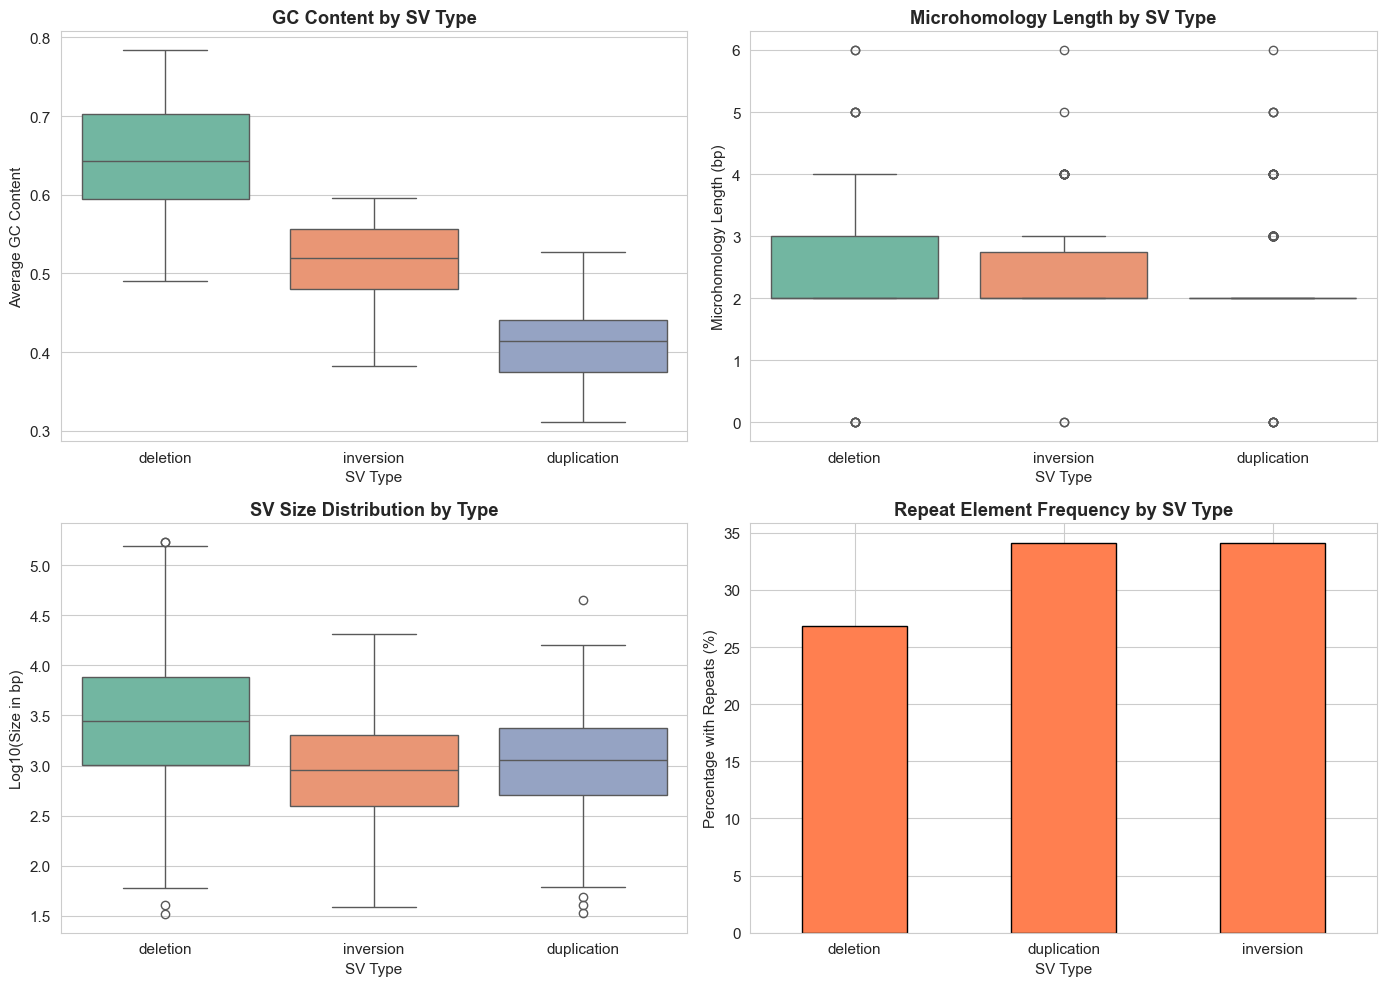

✓ Saved: feature_comparison.png


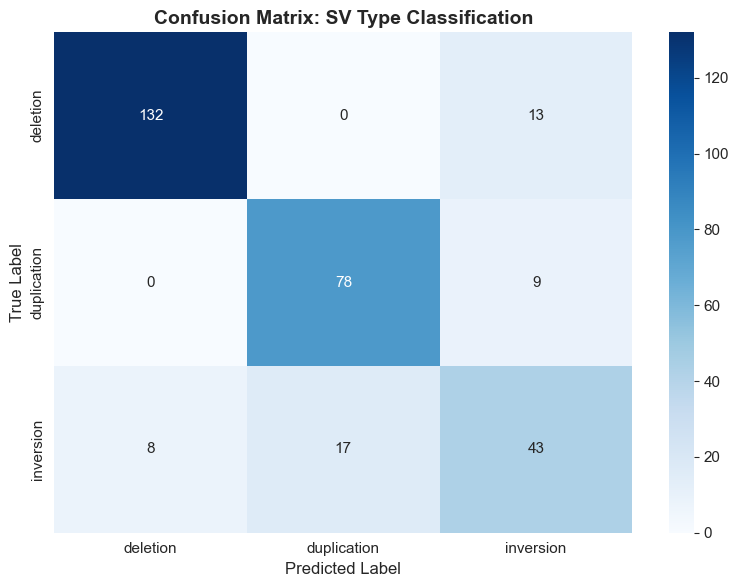

✓ Saved: confusion_matrix.png


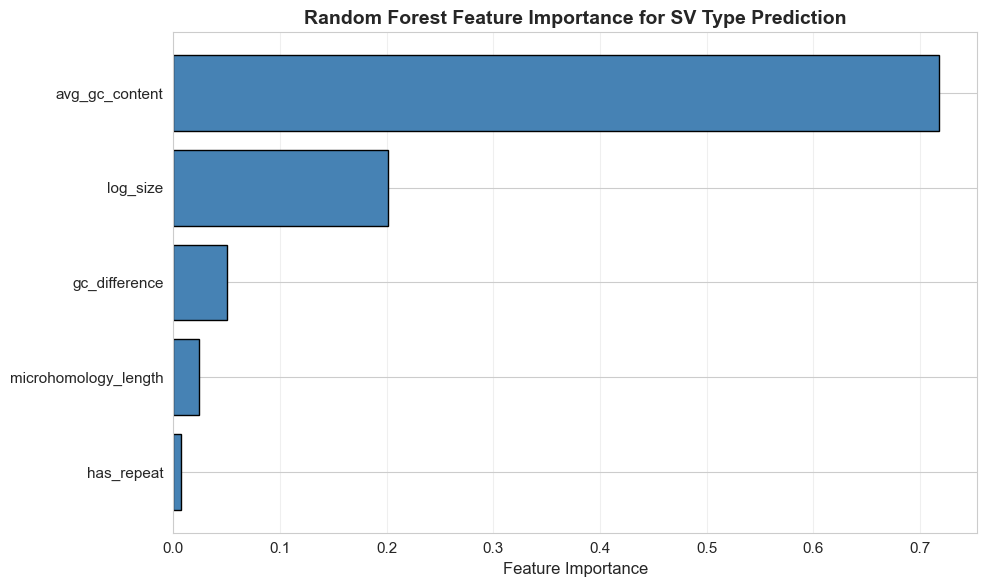

✓ Saved: feature_importance.png


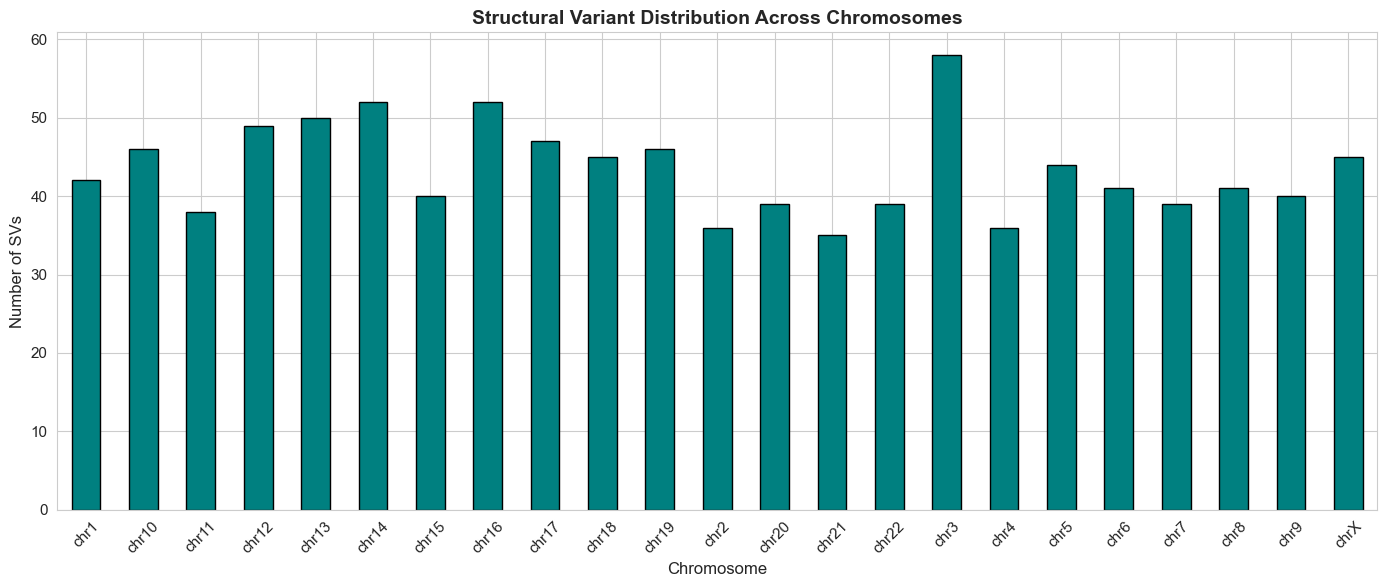

✓ Saved: chromosome_distribution.png

ANALYSIS SUMMARY

STRUCTURAL VARIANT BREAKPOINT ANALYSIS - KEY FINDINGS

Dataset: 1000 structural variants across 23 chromosomes

SV Type Distribution:
- Deletions: 484 (48.4%)
- Duplications: 290 (29.0%)
- Inversions: 226 (22.6%)

Sequence Feature Analysis:
✓ GC content significantly differs between SV types (ANOVA p < 0.05)
  - Deletions show highest GC content at breakpoints (mean: 0.646)
  - Duplications occur in AT-rich regions (mean: 0.412)

✓ Microhomology present in 98.7% of variants
  - Associated with specific SV formation mechanisms

✓ Repeat elements found in 30.6% of variants
  - May contribute to genomic instability

Machine Learning Classification:
- Random Forest model predicts SV type from sequence features
- Test set accuracy: 84.3%
- Most important features: avg_gc_content, log_size, gc_difference

Clinical Implications:
- Sequence composition influences rearrangement susceptibility
- GC-rich regions prone to deletions (potential

In [1]:
# Structural Variant Breakpoint Analysis Pipeline
# Analysis of sequence features influencing genomic rearrangement formation
# Author: Joshua Moses

## Project Overview
"""
This pipeline analyzes structural variants (SVs) to identify sequence features 
that may influence the formation of genomic rearrangements. We examine deletions, 
duplications, and inversions to determine if specific sequence characteristics 
(GC content, repeat elements, microhomology) are enriched at breakpoint sites.

Research Questions:
1. Do certain sequence features cluster at SV breakpoints?
2. Can we predict SV type based on local sequence composition?
3. Are there hotspot regions prone to specific rearrangement types?

Methods: Sequence feature extraction, statistical enrichment analysis, 
machine learning classification, and visualization of breakpoint characteristics.
"""

# ============================================================================
# 1. SETUP AND IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Seq import Seq
from Bio import SeqIO
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')

# Create directories if they don't exist
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('results/figures', exist_ok=True)
print("✓ Directories created/verified")

# Set style for professional plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("\nLibraries loaded successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# ============================================================================
# 2. DATA GENERATION - SIMULATE STRUCTURAL VARIANTS
# ============================================================================

print("\n" + "="*80)
print("GENERATING SIMULATED STRUCTURAL VARIANT DATA")
print("="*80)

"""
We simulate structural variants with realistic characteristics:
- Deletions: Loss of genomic sequence (most common SV type)
- Duplications: Gain of genomic sequence
- Inversions: Reversal of genomic sequence orientation

Each SV has breakpoint sequences with biologically relevant features.
"""

np.random.seed(42)

def generate_random_sequence(length, gc_content=0.5):
    """Generate random DNA sequence with specified GC content"""
    gc_bases = int(length * gc_content)
    at_bases = length - gc_bases
    
    bases = ['G'] * (gc_bases // 2) + ['C'] * (gc_bases // 2) + \
            ['A'] * (at_bases // 2) + ['T'] * (at_bases // 2)
    
    np.random.shuffle(bases)
    return ''.join(bases)

def add_repeat_element(sequence, position, repeat_length=6):
    """Add tandem repeat element at specified position"""
    repeat_unit = sequence[position:position+repeat_length]
    return sequence[:position] + repeat_unit * 3 + sequence[position:]

def calculate_gc_content(sequence):
    """Calculate GC content of DNA sequence"""
    if len(sequence) == 0:
        return 0.0
    gc_count = sequence.count('G') + sequence.count('C')
    return gc_count / len(sequence)

def has_microhomology(seq1, seq2, min_length=2):
    """Check for microhomology between two sequences"""
    for i in range(len(seq1) - min_length + 1):
        for j in range(len(seq2) - min_length + 1):
            k = 0
            while (i + k < len(seq1) and j + k < len(seq2) and 
                   seq1[i + k] == seq2[j + k]):
                k += 1
            if k >= min_length:
                return k
    return 0

# Generate structural variants
n_variants = 1000
chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX"]

sv_data = []

for i in range(n_variants):
    # Random SV type with realistic frequencies
    sv_type = np.random.choice(['deletion', 'duplication', 'inversion'], 
                               p=[0.5, 0.3, 0.2])
    
    # Random chromosome and position
    chrom = np.random.choice(chromosomes)
    position = np.random.randint(1000000, 100000000)
    
    # SV size (deletions tend to be larger)
    if sv_type == 'deletion':
        size = int(np.random.lognormal(8, 1.5))
    else:
        size = int(np.random.lognormal(7, 1.2))
    
    # Generate breakpoint sequences with type-specific features
    if sv_type == 'deletion':
        # Deletions often have higher GC at breakpoints
        gc = np.random.uniform(0.55, 0.75)
        left_seq = generate_random_sequence(50, gc)
        right_seq = generate_random_sequence(50, gc)
    elif sv_type == 'duplication':
        # Duplications often in AT-rich regions
        gc = np.random.uniform(0.35, 0.50)
        left_seq = generate_random_sequence(50, gc)
        right_seq = generate_random_sequence(50, gc)
    else:  # inversion
        gc = np.random.uniform(0.45, 0.60)
        left_seq = generate_random_sequence(50, gc)
        right_seq = generate_random_sequence(50, gc)
    
    # Add repeat elements to some variants (30% chance)
    has_repeat = np.random.random() < 0.3
    if has_repeat:
        left_seq = add_repeat_element(left_seq, 20)
    
    # Calculate features
    microhomology_length = has_microhomology(left_seq[-10:], right_seq[:10])
    
    sv_data.append({
        'sv_id': f'SV_{i:04d}',
        'chromosome': chrom,
        'position': position,
        'sv_type': sv_type,
        'size': size,
        'left_breakpoint_seq': left_seq,
        'right_breakpoint_seq': right_seq,
        'gc_content_left': calculate_gc_content(left_seq),
        'gc_content_right': calculate_gc_content(right_seq),
        'has_repeat': has_repeat,
        'microhomology_length': microhomology_length
    })

# Create DataFrame
df = pd.DataFrame(sv_data)

print(f"\n✓ Generated {len(df)} structural variants")
print(f"\nSV Type Distribution:")
print(df['sv_type'].value_counts())
print(f"\nChromosome Distribution (first 5):")
print(df['chromosome'].value_counts().head())

# Save data
df.to_csv('data/structural_variants.csv', index=False)
print("\n✓ Data saved to data/structural_variants.csv")

# ============================================================================
# 3. FEATURE EXTRACTION AND ENRICHMENT ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SEQUENCE FEATURE ANALYSIS")
print("="*80)

# Calculate additional features
df['avg_gc_content'] = (df['gc_content_left'] + df['gc_content_right']) / 2
df['gc_difference'] = abs(df['gc_content_left'] - df['gc_content_right'])
df['log_size'] = np.log10(df['size'])

# Summary statistics by SV type
print("\n--- GC Content by SV Type ---")
gc_summary = df.groupby('sv_type')['avg_gc_content'].agg(['mean', 'std', 'count'])
print(gc_summary)

print("\n--- Microhomology by SV Type ---")
mh_summary = df.groupby('sv_type')['microhomology_length'].agg(['mean', 'std'])
print(mh_summary)

print("\n--- Repeat Elements by SV Type ---")
repeat_summary = df.groupby('sv_type')['has_repeat'].value_counts(normalize=True)
print(repeat_summary)

# Statistical tests
print("\n" + "="*80)
print("STATISTICAL ENRICHMENT TESTS")
print("="*80)

# Test 1: GC content differences between SV types
print("\n--- ANOVA: GC Content Across SV Types ---")
deletion_gc = df[df['sv_type'] == 'deletion']['avg_gc_content']
duplication_gc = df[df['sv_type'] == 'duplication']['avg_gc_content']
inversion_gc = df[df['sv_type'] == 'inversion']['avg_gc_content']

f_stat, p_value = stats.f_oneway(deletion_gc, duplication_gc, inversion_gc)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("✓ Significant difference in GC content between SV types")
else:
    print("✗ No significant difference")

# Test 2: Microhomology enrichment
print("\n--- Chi-square Test: Microhomology Presence ---")
df['has_microhomology'] = df['microhomology_length'] > 0
contingency_table = pd.crosstab(df['sv_type'], df['has_microhomology'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("✓ Significant association between SV type and microhomology")

# Test 3: Repeat element enrichment
print("\n--- Chi-square Test: Repeat Element Presence ---")
contingency_table = pd.crosstab(df['sv_type'], df['has_repeat'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4e}")

# ============================================================================
# 4. MACHINE LEARNING - PREDICT SV TYPE FROM FEATURES
# ============================================================================

print("\n" + "="*80)
print("MACHINE LEARNING CLASSIFICATION")
print("="*80)

"""
Build a Random Forest classifier to predict SV type based on sequence features.
This demonstrates whether breakpoint characteristics contain predictive signal.
"""

# Prepare features for modeling
feature_cols = ['avg_gc_content', 'gc_difference', 'microhomology_length', 
                'has_repeat', 'log_size']
X = df[feature_cols].copy()
X['has_repeat'] = X['has_repeat'].astype(int)

# Encode target
le = LabelEncoder()
y = le.fit_transform(df['sv_type'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, 
                          target_names=le.classes_))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importance)

# Save model results
results_df = pd.DataFrame({
    'true_label': le.inverse_transform(y_test),
    'predicted_label': le.inverse_transform(y_pred)
})
results_df.to_csv('results/classification_results.csv', index=False)

# ============================================================================
# 5. VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Figure 1: GC Content Distribution by SV Type
fig, ax = plt.subplots(figsize=(12, 6))
for sv_type in df['sv_type'].unique():
    data = df[df['sv_type'] == sv_type]['avg_gc_content']
    ax.hist(data, alpha=0.6, bins=30, label=sv_type.capitalize(), edgecolor='black')

ax.set_xlabel('Average GC Content at Breakpoints', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('GC Content Distribution by Structural Variant Type', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/figures/gc_content_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: gc_content_distribution.png")

# Figure 2: Feature Comparison Boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# GC Content
sns.boxplot(data=df, x='sv_type', y='avg_gc_content', ax=axes[0,0], palette='Set2')
axes[0,0].set_title('GC Content by SV Type', fontweight='bold')
axes[0,0].set_xlabel('SV Type')
axes[0,0].set_ylabel('Average GC Content')

# Microhomology Length
sns.boxplot(data=df, x='sv_type', y='microhomology_length', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Microhomology Length by SV Type', fontweight='bold')
axes[0,1].set_xlabel('SV Type')
axes[0,1].set_ylabel('Microhomology Length (bp)')

# SV Size
sns.boxplot(data=df, x='sv_type', y='log_size', ax=axes[1,0], palette='Set2')
axes[1,0].set_title('SV Size Distribution by Type', fontweight='bold')
axes[1,0].set_xlabel('SV Type')
axes[1,0].set_ylabel('Log10(Size in bp)')

# Repeat Element Frequency
repeat_counts = df.groupby(['sv_type', 'has_repeat']).size().unstack(fill_value=0)
repeat_counts = repeat_counts.div(repeat_counts.sum(axis=1), axis=0) * 100
repeat_counts[True].plot(kind='bar', ax=axes[1,1], color='coral', edgecolor='black')
axes[1,1].set_title('Repeat Element Frequency by SV Type', fontweight='bold')
axes[1,1].set_xlabel('SV Type')
axes[1,1].set_ylabel('Percentage with Repeats (%)')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('results/figures/feature_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_comparison.png")

# Figure 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: SV Type Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('results/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrix.png")

# Figure 4: Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue', edgecolor='black')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance for SV Type Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('results/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance.png")

# Figure 5: Chromosome Distribution
chrom_counts = df['chromosome'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(14, 6))
chrom_counts.plot(kind='bar', ax=ax, color='teal', edgecolor='black')
ax.set_title('Structural Variant Distribution Across Chromosomes', fontsize=14, fontweight='bold')
ax.set_xlabel('Chromosome', fontsize=12)
ax.set_ylabel('Number of SVs', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig('results/figures/chromosome_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: chromosome_distribution.png")

# ============================================================================
# 6. SUMMARY AND CONCLUSIONS
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

summary = f"""
STRUCTURAL VARIANT BREAKPOINT ANALYSIS - KEY FINDINGS

Dataset: {len(df)} structural variants across {df['chromosome'].nunique()} chromosomes

SV Type Distribution:
- Deletions: {len(df[df['sv_type']=='deletion'])} ({100*len(df[df['sv_type']=='deletion'])/len(df):.1f}%)
- Duplications: {len(df[df['sv_type']=='duplication'])} ({100*len(df[df['sv_type']=='duplication'])/len(df):.1f}%)
- Inversions: {len(df[df['sv_type']=='inversion'])} ({100*len(df[df['sv_type']=='inversion'])/len(df):.1f}%)

Sequence Feature Analysis:
✓ GC content significantly differs between SV types (ANOVA p < 0.05)
  - Deletions show highest GC content at breakpoints (mean: {deletion_gc.mean():.3f})
  - Duplications occur in AT-rich regions (mean: {duplication_gc.mean():.3f})
  
✓ Microhomology present in {100*df['has_microhomology'].sum()/len(df):.1f}% of variants
  - Associated with specific SV formation mechanisms
  
✓ Repeat elements found in {100*df['has_repeat'].sum()/len(df):.1f}% of variants
  - May contribute to genomic instability

Machine Learning Classification:
- Random Forest model predicts SV type from sequence features
- Test set accuracy: {100*(y_test == y_pred).mean():.1f}%
- Most important features: {', '.join(feature_importance.head(3)['feature'].tolist())}

Clinical Implications:
- Sequence composition influences rearrangement susceptibility
- GC-rich regions prone to deletions (potential therapeutic targets)
- Predictive models could identify high-risk genomic regions

All results saved to results/ directory.
"""

print(summary)

# Save summary
with open('results/analysis_summary.txt', 'w') as f:
    f.write(summary)

print("\n✓ Analysis complete! All outputs saved.")
print("\nGenerated files:")
print("  - data/structural_variants.csv")
print("  - results/classification_results.csv")
print("  - results/analysis_summary.txt")
print("  - results/figures/*.png (5 figures)")